This notebook visualises rasters and calculates zonal statistics by township, and inserts results into database table.

In [1]:
import rasterio
from rasterio.plot import show
import geopandas as gpd
from sqlalchemy import create_engine
from sqlalchemy import text
import rasterstats
from rasterstats import zonal_stats
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Create a SQLAlchemy engine
conn_string = "postgresql://lizavabistsevits:@localhost:5432/taiwan" # database connection string
engine = create_engine(conn_string)

# Insert township geom into geodataframe
townships = gpd.read_postgis(
    "SELECT code, name, geom FROM townships", 
    engine, 
    geom_col="geom"
)

townships.head(5)

,code,name,geom
0,68000040,Yangmei District,"MULTIPOLYGON (((265128.924 2760180.407, 265142..."
1,64000160,Dashe District,"MULTIPOLYGON (((189599.603 2517612.872, 189596..."
2,64000140,Daliao District,"MULTIPOLYGON (((191951.502 2503292.163, 191940..."
3,64000150,Dashu District,"MULTIPOLYGON (((193966.334 2519114.849, 193954..."
4,64000330,Jiaxian District,"MULTIPOLYGON (((214323.657 2567413.723, 214356..."


#### Climate zones (Köppen-Geiger climate classification)

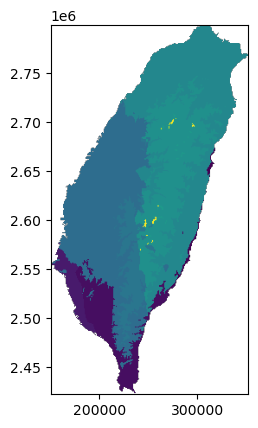

<Axes: >

In [3]:
climate_zones = rasterio.open("../data/koppen_geiger_tif/1991_2020/kg_tw_clipped_3826.tif")
show(climate_zones)

In [4]:
# Calculate zonal statistics for climate zones
zs_cz = zonal_stats(townships, "../data/koppen_geiger_tif/1991_2020/kg_tw_clipped_3826.tif", stats=['majority']) # zonal_stats creates a list of dictionary objects
#print(zs_cz)

In [5]:
# Create dataframe with zonal statistics
stats_cz = pd.DataFrame(zs_cz)
stats_cz.rename(columns={'majority':'major_climate_zone'}, inplace=True)

# Merge with townships
townships = pd.concat([townships, stats_cz], axis=1)

In [6]:
# Insert climate zones into townships table
with engine.begin() as connection:
    for index, row in townships.iterrows():
        query = text("""
            UPDATE townships
            SET main_climate = :climate_zone 
            WHERE code = :township_code
        """)
        connection.execute(query, {"climate_zone": row['major_climate_zone'], "township_code": row['code']})

(2400000.0, 2850000.0)

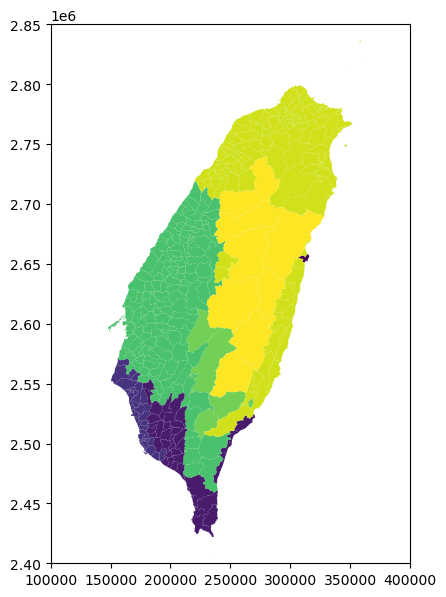

In [7]:
f, ax = plt.subplots(figsize=(7, 7))
townships.plot(
    column='major_climate_zone',
    ax=ax)

# Specify plot coordinates
ax.set_xlim(100000, 400000)
ax.set_ylim(2400000, 2850000)

#### DEM

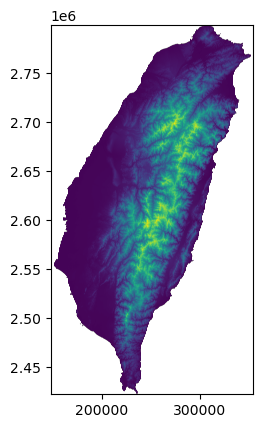

<Axes: >

In [8]:
dem = rasterio.open("../data/elevation/TWN_DEM_3826_Clipped.tif")
show(dem)

In [9]:
# Calculate zonal statistics for elevation (DEM)
zs_dem = zonal_stats(townships, "../data/elevation/TWN_DEM_3826_Clipped.tif", stats=['mean', 'median', 'max'])
#print(zs_dem)

In [10]:
# Create dataframe with zonal statistics
stats_dem = pd.DataFrame(zs_dem)
stats_dem.rename(columns={'mean':'mean_elevation', 'median':'median_elevation', 'max':'max_elevation'}, inplace=True)

# Merge with townships
townships = pd.concat([townships, stats_dem], axis=1)

In [11]:
# Insert elevation into townships table
with engine.begin() as connection:
    for index, row in townships.iterrows():
        query = text("""
            UPDATE townships
            SET elevation = :elevation 
            WHERE code = :township_code
        """)
        connection.execute(query, {"elevation": row['mean_elevation'], "township_code": row['code']})

(2400000.0, 2850000.0)

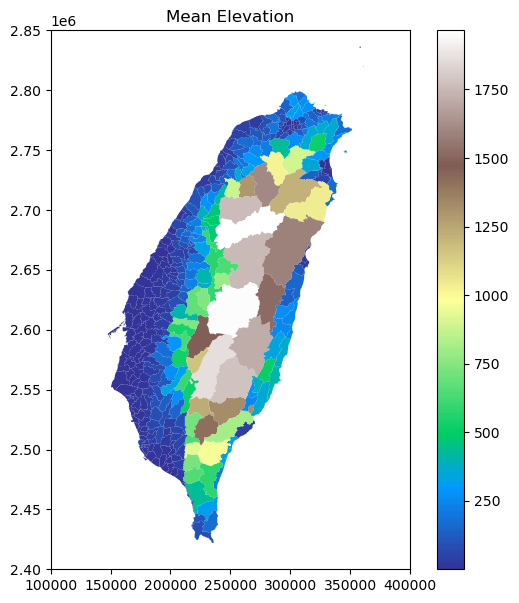

In [12]:
f, ax = plt.subplots(figsize=(7, 7))
townships.plot(
    column='mean_elevation', 
    cmap='terrain',
    legend=True,
    ax=ax)

ax.set_title('Mean Elevation')

# Specify plot coordinates
ax.set_xlim(100000, 400000)
ax.set_ylim(2400000, 2850000)

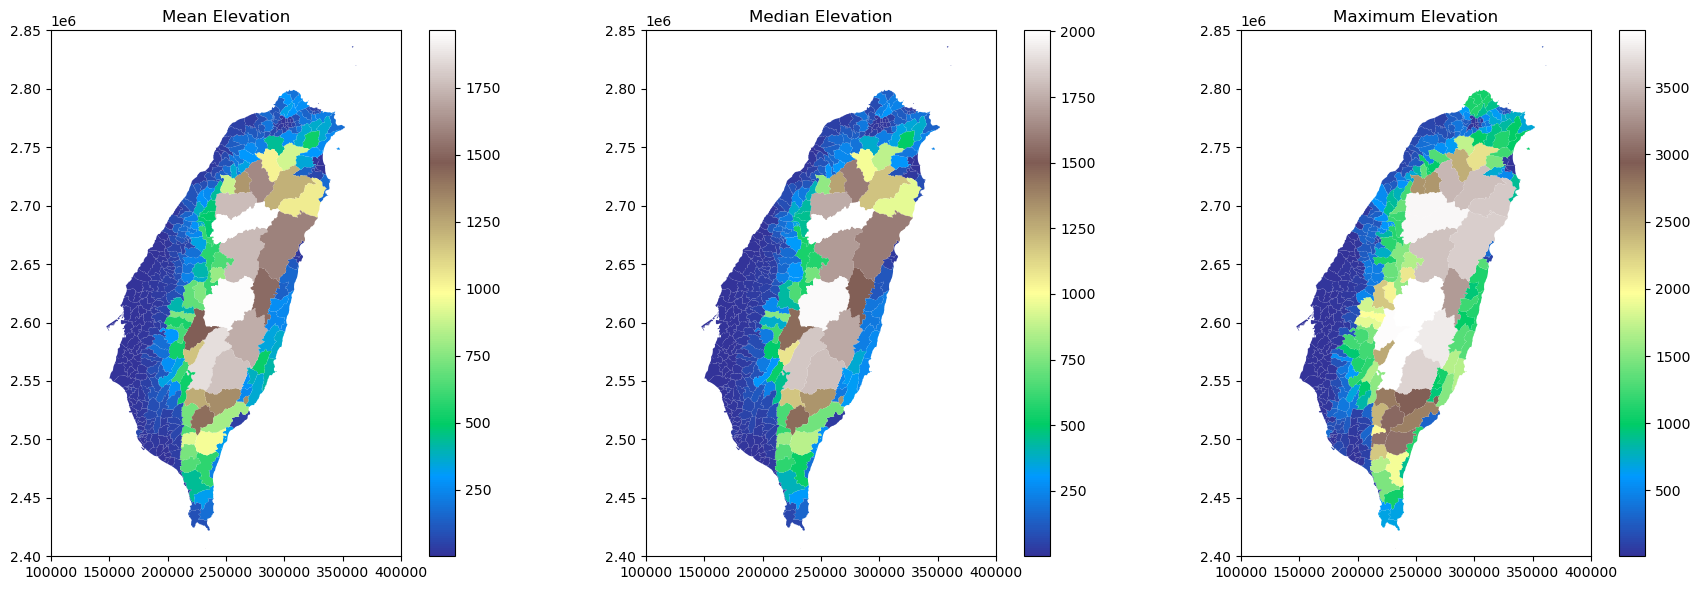

In [13]:
f, axs = plt.subplots(1, 3, figsize=(18, 6))

# Subplot 1 – Mean Elevation
townships.plot(
    column='mean_elevation', 
    cmap='terrain', 
    legend=True, 
    ax=axs[0])

axs[0].set_title('Mean Elevation')

# Subplot 2 – Median Elevation
townships.plot(
    column='median_elevation', 
    cmap='terrain', 
    legend=True, 
    ax=axs[1])

axs[1].set_title('Median Elevation')

# Subplot 3 – Maximum Elevation
townships.plot(
    column='max_elevation', 
    cmap='terrain', 
    legend=True, 
    ax=axs[2])
    
axs[2].set_title('Maximum Elevation')

# Specify plot coordinates
for i in range(3):
    axs[i].set_xlim(100000, 400000)
    axs[i].set_ylim(2400000, 2850000)

plt.tight_layout()

#### Built-up area percentage

In [14]:
land_cover = pd.read_csv('../data/worldcover/zonal_histogram_results.csv', delimiter=',')
land_cover.head()

,code,county,name,total_pop,pop_density,main_climate,elevation,HISTO_0,HISTO_10,HISTO_20,HISTO_30,HISTO_40,HISTO_50,HISTO_60,HISTO_70,HISTO_80,HISTO_90,HISTO_95,histo_total,pct_50
0,68000040,68000,Yangmei District,182572,2036.195871,14.0,169.584657,0,440269,0,42609,259043,310814,12140,0,21746,5,0,1086626,28.604
1,64000160,64000,Dashe District,39864,1572.981313,2.0,46.334724,0,177383,1,5137,21335,101142,1686,0,440,21,0,307145,32.930
2,64000140,64000,Daliao District,123114,1756.679222,2.0,18.708464,0,218655,0,29738,240144,328325,15042,0,17196,237,0,849337,38.657
3,64000150,64000,Dashu District,46754,692.834042,2.0,71.961801,0,559171,15,29244,49392,108289,6779,0,63415,1479,0,817784,13.242
4,64000330,64000,Jiaxian District,3759,30.342466,11.0,601.719399,0,1344400,5,75813,30004,15922,27005,0,8189,0,0,1501338,1.061


In [15]:
# Merge built-up area (code=50) with townships
townships = pd.merge(townships, land_cover[['code', 'pct_50']], on='code', how='left')

# Insert built-up area percentage into townships table
with engine.begin() as connection:
    for index, row in townships.iterrows():
        query = text("""
            UPDATE townships
            SET built_up_area = :built_up_pct 
            WHERE code = :township_code
        """)
        connection.execute(query, {"built_up_pct": row['pct_50'], "township_code": row['code']})